In [22]:
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time
import utils_rev
import yolov4

In [23]:
# Read images

img = cv.imread('assets/images/test15.jpg')
img = cv.resize(img, (416, 416))

mask = np.zeros([416,416,3],np.uint8)

print(img.shape)
print(img.size)
print(img.dtype)

(416, 416, 3)
519168
uint8


In [24]:
# Run detection
model_file = 'yolo_archive/models/yolov4/v4/yolov4-obj_best.weights'
config_file = 'yolo_archive/yolov4-obj.cfg'
labels, scores, bboxes = yolov4.predict(img, model_file, config_file, .25)

In [25]:
img_yolo = img.copy()
for label, score, bbox in zip(labels, scores, bboxes):
    x, y, w, h = bbox
    right = round(x + w)
    left = round(x)
    bottom = round(y + h)
    top = round(y)
    cv.rectangle(img_yolo, (left, top), (right, bottom), (255, 0, 255), 1)
    cv.putText(img_yolo, "{} [{:.2f}]".format('paddy', float(score)),
                (left, top - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5,
                (255, 0, 255), 2)

In [26]:
# Draw corners
img_corners = img.copy()
left_line, right_line, img_corners = utils_rev.process_bboxes(img_corners, bboxes,threshold=60)

In [27]:
# Run Thresholding
img_thresh = utils_rev.thresholding(img_corners, 150, 150, 255, 255, 255, 255)

In [28]:
# Run Canny Edge Detection
img_edges = cv.Canny(img_thresh, 150, 255, apertureSize=3)

In [29]:
lines = cv.HoughLinesP(img_edges, 1, np.pi/180, 10, np.array([]), minLineLength=10, maxLineGap=50)

img_hough_1 = img.copy()
for line in lines:
    x1, y1, x2, y2 = line.reshape(4)
    cv.line(img_hough_1, (round(x1), round(y1)), (round(x2), round(y2)), (0, 255, 0), 5)

left_fit = []
right_fit = []
left_inf = []
right_inf = []
center_x = img.shape[1] // 2
for line in lines:
    x1, y1, x2, y2 = line.reshape(4)
    if x1 != x2:
        m, b = np.polyfit((x1, x2), (y1, y2), 1)
        angle = np.rad2deg(np.arctan2(y2 - y1, x2 - x1))
        if angle < 0:
            angle += 180
        if not (70 <= angle <= 110):
            continue

        midpoint_x = (x1 + x2) / 2
        print(line)
        print(midpoint_x)
        if midpoint_x < center_x:
            left_fit.append((m, b))
        else:
            right_fit.append((m, b))
    else:
        midpoint_x = (x1 + x2) / 2
        if midpoint_x < center_x:
            left_inf.append((x1, int(img.shape[0]), x2, int(img.shape[0]*1/3)))
        else:
            right_inf.append((x1, int(img.shape[0]), x2, int(img.shape[0]*1/3)))

if len(left_fit) > len(left_inf):
    left_fit_avg = np.average(left_fit, axis=0)
    left_line = utils_rev.make_coordinates(img, left_fit_avg)
else:
    left_line = np.array(left_inf)
    left_line = np.average(left_line, axis=0)
    left_fit_avg = [float('inf'), left_line[0]]
if len(right_fit) > len(right_inf):
    right_fit_avg = np.average(right_fit, axis=0)
    right_line = utils_rev.make_coordinates(img, right_fit_avg)
else:
    right_line = np.array(right_inf)
    right_line = np.average(right_line, axis=0)
    right_fit_avg = [float('inf'), right_line[0]]
averaged = np.array([left_line, right_line])
slopes = np.array([left_fit_avg, right_fit_avg])

line_image = np.zeros_like(img)
if averaged is not None:
    for line in averaged:
        x1, y1, x2, y2 = line.reshape(4)
        cv.line(line_image, (round(x1), round(y1)), (round(x2), round(y2)), (0, 255, 0), 5)
result_img = cv.addWeighted(img, 0.8, line_image, 1, 1)

[[232 136 233 146]]
232.5
[[233 136 234 146]]
233.5
[[237 214 238 224]]
237.5
[[245 296 246 306]]
245.5
[[158 136 159 146]]
158.5
[[226  58 227  68]]
226.5
[[162 214 163 224]]
162.5
[[244 296 245 306]]
244.5
[[163 214 164 224]]
163.5
[[157 136 158 146]]
157.5


In [30]:
img_guide = result_img.copy()
utils_rev.tractor_guidance(img_guide, averaged, 20)

(52,
 23,
 -29,
 -1,
 array([[[121, 125, 132],
         [127, 132, 139],
         [127, 133, 141],
         ...,
         [123, 124, 131],
         [126, 127, 134],
         [121, 123, 129]],
 
        [[124, 129, 136],
         [128, 135, 142],
         [126, 134, 142],
         ...,
         [114, 115, 122],
         [103, 104, 111],
         [111, 113, 119]],
 
        [[129, 135, 142],
         [136, 143, 150],
         [131, 139, 147],
         ...,
         [112, 114, 119],
         [113, 115, 121],
         [116, 118, 124]],
 
        ...,
 
        [[122, 125, 131],
         [141, 143, 150],
         [125, 127, 134],
         ...,
         [110, 112, 119],
         [117, 119, 126],
         [131, 134, 140]],
 
        [[115, 118, 124],
         [139, 142, 148],
         [119, 122, 128],
         ...,
         [115, 117, 123],
         [117, 119, 126],
         [127, 129, 135]],
 
        [[ 96,  99, 105],
         [132, 135, 141],
         [117, 119, 126],
         ...,
       

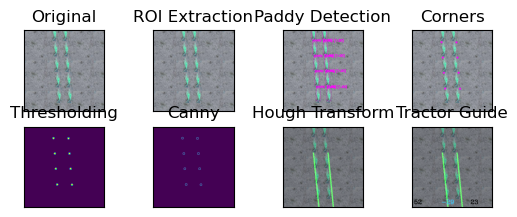

In [31]:
titles = ['Original', 'ROI Extraction', 'Paddy Detection', 'Corners', 'Thresholding', 'Canny', 'Hough Transform', 'Tractor Guide']
images = [img, img, img_yolo, img_corners, img_thresh, img_edges, result_img, img_guide]

for i in range(len(images)):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])

plt.show()

In [ ]:
# Thresholding
img = cv.imread('test2.jpg',0)
_, th1 = cv.threshold(img, 200, 255, cv.THRESH_BINARY)
_, th2 = cv.threshold(img, 100, 150, cv.THRESH_BINARY_INV)
_, th3 = cv.threshold(img, 200, 255, cv.THRESH_TRUNC)
_, th4 = cv.threshold(img, 200, 255, cv.THRESH_TOZERO)
_, th5 = cv.threshold(img, 200, 255, cv.THRESH_TOZERO_INV)
th6 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 101, 2)
th7 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 101, 2)

titles = ['original', 'BINARY', 'BINARY INV', 'TRUNC', 'TO ZERO', 'TO ZERO INV', 'ADAPTIVE MEAN', 'ADAPTIVE GAUSSIAN']
images = [img, th1, th2, th3, th4, th5, th6, th7]

for i in range(len(images)):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])

plt.show()

In [ ]:
# Create bounding boxes
img_rect = img.copy()
coordinates = np.array([
    [[20, 20], [80, 80]],
    [[40, 100], [100, 160]],
    [[60, 180], [120, 240]],
    [[80, 260], [140, 320]],
    [[100, 340], [160, 400]],
    [[120, 420], [180, 480]],
    [[220, 20], [280, 80]],
    [[240, 100], [300, 160]],
    [[260, 180], [320, 240]],
    [[280, 260], [340, 320]],
    [[300, 340], [360, 400]],
    [[320, 420], [380, 480]]
])

for c1, c2 in coordinates:
    cv.rectangle(img_rect, c1, c2, (255, 0, 255), 2)
plt.imshow(img_rect)
plt.show()

In [ ]:
# Extract the center of the bounding boxes
centers = []
for c1, c2 in coordinates:
    x_center = (c1[0]+c2[0])//2
    y_center = (c1[1]+c2[1])//2
    centers.append([x_center, y_center])

centers = np.array(centers)
print(centers)

# Draw the centers as dots on the image
img_centers = img.copy()
print(img_centers.dtype)
for center in centers:
    cv.circle(img_centers, center, 5, (255, 0, 255), -1)
print(img_centers.dtype)
plt.imshow(img_centers)
plt.show()

In [ ]:
# Thresholding to separate bounding boxes with backgrounds
# color_detection.detect_color_img(img_rect)
img_thresh = utils.thresholding(img_centers, 150, 150, 255, 255, 255, 255)
plt.imshow(img_thresh, cmap='gray')
plt.show()
# Note
#   h = (150, 150)
#   s = (255, 255)
#   v = (255, 255)

In [ ]:
# Hough Transform
img_hough = img_centers.copy()
gray = cv.cvtColor(img_hough,cv.COLOR_BGR2GRAY)
edges = cv.Canny(img_thresh, 150, 255, apertureSize=3)
lines = cv.HoughLines(edges,1,np.pi/180,30)
if lines is not None:
    for line in lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv.line(img_hough,(x1,y1),(x2,y2),(0,0,255),2)

# Probability Hough Transform
img_houghp = img_centers.copy()
edges = cv.Canny(img_thresh, 150, 255, apertureSize=3)
lines = cv.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=30, minLineLength=40, maxLineGap=80)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv.line(img_houghp, (x1, y1), (x2, y2), (0, 0, 255), 2)

images = [img_rect, edges, img_hough, img_houghp]
titles = ['input', 'canny', 'hough', 'houghp']
for i in range(len(images)):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
# Custom Hough Transform
img_lane = img_thresh.copy()
# if img_lane.ndim == 3:
#     img_lane = cv.COLOR_BGR2GRAY(img_lane)
accumulator, theta, rho = hough_transform.hough_line(img_lane)
hough_transform.show_hough_line(img, accumulator, theta, rho, path='')

In [ ]:
# Linearization
img_linear = img_rect
for c1, c2 in coordinates:
    x1, y1 = c1
    x2, y2 = c2
    cv.line(img_linear, (x1, y1), (x2, y2), (255, 0, 255), 1)
plt.imshow(img_linear)
plt.show()